# Lab Three Multi-modal and Multi-task
student name: bochuan wu

# requirement
In this lab, you will implement a multi-task network (possibly multi-modal) that classifies interactions between compounds and ligands in the ChEMBL database (https://www.ebi.ac.uk/chembl/ ). The objective is to classify which ligands bind to which targets. Each target will be a separate task working from a  shared ligand representation. 

The following grading rubric will be used:

[10 points] Download the ChEMBL database or setup queries to download a subset go the database.(done)

[20 points] Filter the database to the top 100 targets in the database. You will need a definition of "top" such as the targets with the most assays. From these top 100 targets, save the ligands that have an assay result for each of the targets. (done)

[5 points] Binarize the binding affinity for each ligand in the assay. That is, convert the continuous measure of binding to binary. You should use the column 'IC50' for this calculation. Anything below 300 nM should be considered as an active binding. Anything above 10 uM should be considered non-binding (inactive). (done)

[10 points] Featurize each ligand using RDKit (https://www.rdkit.org). This will convert the ligand representation into a binary vector of features. Mention any hyper parameters you use.(done)

[10 points] Train a multi-task model (one model for each target). Use an 80/20 split for each target.(done)

[20 points] Report the results using AUC, BEDROC, and Enrichment factor. These metrics are easily calculated using the RDKit scoring library. Discuss the results (you will need to look up each evaluation metric to interpret the result). You may be interested in page 6 of the following document: https://www.dropbox.com/s/6je37ml475vg3ep/Srinivas2018ImplictDescriptorUnderReview.pdf?dl=0 (done)

[10 points] Finally, you have free reign to perform any other analysis. A suggested analysis is to add an additional mode of input data such as another fingerprint for each ligand. (done)

# ChemBL
ChEMBL is an actively maintained and used chemical database of bioactive molecules with drug-like properties. The European Bioinformatics Institute (EBI) is in charge of keeping up to date with it.

# Exploratory Data Analysis(EDA)
*  Data Collection
*  Visualization
*  Data Preprocessing

##  Data Collection

In [1]:
import numpy as np

f = open('data.csv', 'r', encoding="ISO-8859-1")
lines = f.readlines()
f.close()
flis = [] # will have [id, ic50_val, unit, target, smiles] 
l=0

for line in lines[1:]: # first line contains the headers (therefore skiped)
    # clean up the dataset 
    line = line.replace('\x00','')
    line = line.replace('",','"!')
    line = line.replace('"','')
    lis = line.strip().split('!')
    l=1
    if len(lis) < 36:
        continue
    flis.append([lis[0], lis[3], lis[4], lis[8], lis[36]])



In [2]:
len(flis)


1065319

## Data Preprocessing

In [3]:
# Some of the data have smiles or IC50 missing
# removed them 
lists = []
for i in flis:
    if len(i[1]) != 0 and len(i[-1]) != 0:
        #print (i)
        lists.append(i)


In [4]:
from pandas import DataFrame
df = DataFrame(flis, columns = ['ids', 'ic50_val', 'unit', 'target', 'smiles'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065319 entries, 0 to 1065318
Data columns (total 5 columns):
ids         1065319 non-null object
ic50_val    1065319 non-null object
unit        1065319 non-null object
target      1065319 non-null object
smiles      1065319 non-null object
dtypes: object(5)
memory usage: 40.6+ MB


In [6]:
df.head(5)

,ids,ic50_val,unit,target,smiles
0,CHEMBL17430,11600,nM,CHEMBL664913,Nc1nc(N)c2c(CSc3ccc(Cl)c(Cl)c3)c[nH]c2n1
1,CHEMBL119370,9000,nM,CHEMBL812106,NC(=S)\N=N\c1c(O)[nH]c2ccc(I)cc12
2,CHEMBL239370,17900,nM,CHEMBL811877,[Cl-].C[N+](C)(CCCN1c2ccccc2Sc3ccc(Cl)cc13)Cc4...
3,CHEMBL61415,4200,nM,CHEMBL664920,COc1cc(OC)cc(c1)N(C)Cc2c[nH]c3nc(N)nc(O)c23
4,CHEMBL22,2700,nM,CHEMBL664913,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC


In [7]:
#count frequency of target
def count(df):
    count_dic=dict(zip(*np.unique(df['target'],return_counts=True)))
    return df['target'].apply(lambda x:count_dic[x] ) 


In [8]:
df['count'] = count(df) 

In [9]:
df.head(5)

,ids,ic50_val,unit,target,smiles,count
0,CHEMBL17430,11600,nM,CHEMBL664913,Nc1nc(N)c2c(CSc3ccc(Cl)c(Cl)c3)c[nH]c2n1,16
1,CHEMBL119370,9000,nM,CHEMBL812106,NC(=S)\N=N\c1c(O)[nH]c2ccc(I)cc12,33
2,CHEMBL239370,17900,nM,CHEMBL811877,[Cl-].C[N+](C)(CCCN1c2ccccc2Sc3ccc(Cl)cc13)Cc4...,19
3,CHEMBL61415,4200,nM,CHEMBL664920,COc1cc(OC)cc(c1)N(C)Cc2c[nH]c3nc(N)nc(O)c23,17
4,CHEMBL22,2700,nM,CHEMBL664913,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,16


In [10]:
#find the frequency count for 100th target
rank = df['target'].value_counts()
c=0
for i in rank:
    if c == 100:
        print(i)
        break
    c += 1

871


In [11]:
df = df[df['count']>=871]

In [12]:
#convert ic50 to float type
import pandas as pd

df['ic50_val']= pd.to_numeric(df['ic50_val'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111077 entries, 16863 to 1064540
Data columns (total 6 columns):
ids         111077 non-null object
ic50_val    24776 non-null float64
unit        111077 non-null object
target      111077 non-null object
smiles      111077 non-null object
count       111077 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 5.9+ MB


In [14]:
def filter(x):
    if x > 10000:
        return int(1)
    elif x < 300:
        return int(0)
    else:
        return

In [15]:
df['output']=df['ic50_val'].apply(filter)
df = df.dropna(axis=0,how='any')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15259 entries, 17840 to 1064540
Data columns (total 7 columns):
ids         15259 non-null object
ic50_val    15259 non-null float64
unit        15259 non-null object
target      15259 non-null object
smiles      15259 non-null object
count       15259 non-null int64
output      15259 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 953.7+ KB


In [17]:
df.head(5)

,ids,ic50_val,unit,target,smiles,count,output
17840,CHEMBL1479490,50000.00,nM,CHEMBL1614432,Cc1ccc(cc1)N(CC(=O)NC2CCCC2)C(=O)c3ccc(C)s3,1128,1.0
17843,CHEMBL1502002,18963.56,nM,CHEMBL1614432,CCOC(=O)C1CCCN(C1)c2ccc(c3nonc23)[N+](=O)[O-],1128,1.0
17845,CHEMBL1462559,14819.11,nM,CHEMBL1614432,OCc1ccc(CO[C@H]2C[C@H](C=C(O2)C(=O)N3CCCCCCC3)...,1128,1.0
18068,CHEMBL1313596,13997.64,nM,CHEMBL1614432,COc1ccc(COC(=O)Nc2cc3c(nn(C)c3s2)C(F)(F)F)cc1,1128,1.0
18072,CHEMBL3191794,15131.44,nM,CHEMBL1614432,Cc1[nH]c2ccccc2c1\C=N\NC(=S)NCc3ccccc3,1128,1.0


# Visualization

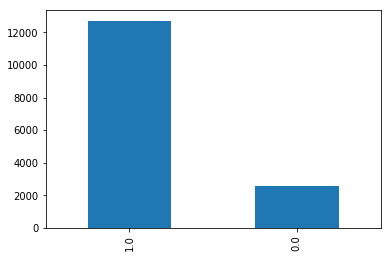

In [18]:
%matplotlib inline
# it is a real imbalance dataset, and it may influence the result
df['output'].value_counts().plot.bar()

In [19]:
targets=[]
for t in df['target']:
    targets.append(t)
len(targets)

15259

In [20]:
print("Number of unique tasks  : {}".format( df['target'].nunique()))
tasks = df['target'].unique()

Number of unique tasks  : 111


# Using RDkit to get feature

In [21]:
from __future__ import print_function

from rdkit import Chem
from rdkit.Chem import MACCSkeys, AllChem
from rdkit.Avalon import pyAvalonTools as fpAvalon
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.ChemicalFeatures import BuildFeatureFactory
from rdkit.Chem import rdMolDescriptors
import pandas as pd
import argparse
import textwrap
import getopt
from argparse import ArgumentParser
import time
trains=[]
c = 0
def CalculateFP_mod(smiles, N_BITS=512):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        raise ValueError('SMILES cannot be converted to a RDKit molecules:', smiles)

    return AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=N_BITS)
for smile in df['smiles']:
    temp = CalculateFP_mod(smile)
    strFP = temp.ToBitString()
    trains.append(strFP)



          

In [22]:
data=[]
for train in trains:
    data.append(list(train))

In [23]:
print('dataset length: {}'.format(len(data)))
print('feature length:{}'.format(len(data[0])))

dataset length: 15259
feature length:512


In [24]:
df['smiles'] = data

In [25]:
df.head(1)

,ids,ic50_val,unit,target,smiles,count,output
17840,CHEMBL1479490,50000.0,nM,CHEMBL1614432,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1128,1.0


# Multi-Task Model

In [26]:
all_comp_data = []
all_comp_test = []
from sklearn.model_selection import train_test_split
#build dataset
%matplotlib inline
from sklearn.datasets.base import Bunch
for t in range(len(tasks)):
    ID = t
    y = np.array(df[df.target.str.contains(tasks[t])]['output'])
    x = np.array(df[df.target.str.contains(tasks[t])]['smiles'])
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12)
    
    for row, target in zip(X_train, y_train):
        instance = {}
        instance["data"] =np.array(row).reshape((1,512))
        instance["subject"] = ID
        instance["target"] = [target]
        all_comp_data.append(instance)
        
    for row, target in zip(X_test, y_test):
        instance = {}
        instance["data"] = np.array(row).reshape(( 1 ,512))
        instance["subject"] = ID
        instance["target"] = [target]
        all_comp_test.append(instance)
   

In [27]:
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(512,))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

models_mtl = []

for _ in range(len(tasks)):
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1, activation='sigmoid')(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    models_mtl.append(model)
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_223 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_224 (Dense)            (None, 1)                 11        
Total params: 37,653
Trainable params: 37,653
Non-trainable params: 0
_________________________________________________________________


In [28]:
import random
random.shuffle(all_comp_data)

In [29]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

EPOCHS = 10
i=0
for _underscore in range(10):
    for instance in all_comp_data:
        models_mtl[instance["subject"]].train_on_batch(x = instance["data"], y = instance["target"])

Instructions for updating:
Use tf.cast instead.


In [ ]:
for i , model in enumerate(models_mtl):
    model.save('./model/model{}.h5'.format(i))

# Prediction and AUC
ROC's full name is 'Receiver Operating Characteristic'. and AUC(Area Under the Curve) is the area under that ROC Curve.

In [66]:
from sklearn.metrics import roc_auc_score
computer_ya = [ [] for x in range(190)]
computer_yhata = [ [] for x in range(190)]
# generate prediction for data
preds = []
y_tests = []
for test in all_comp_test:
    X_test = test["data"]
    y_test = test["target"]
    
    mlp = models_mtl[test["subject"]]
    
    yhat_mlp = mlp.predict(X_test)
    preds.append(yhat_mlp[0])
    y_tests.append(y_test)
auc  = roc_auc_score(y_tests, preds)
print(auc)


0.9914954957598522


# Enrichment Factor
Enrichment Factor is defined as the ratio of correctly classified active ligand within a predefined early recognition threshold compared to the total ligands selected by the model, further normalized by the expected random selection of the ligands

In [31]:
#source code from rdkit.ML.scoring.scoring
import math
from collections import namedtuple

def CalcEnrichment(scores, col, fractions):
  """ Determines the enrichment factor for a set of fractions """
  numMol = len(scores)
  if numMol == 0:
    raise ValueError('score list is empty')
  if len(fractions) == 0:
    raise ValueError('fraction list is empty')
  for i in fractions:
    if i > 1 or i < 0:
      raise ValueError('fractions must be between [0,1]')

  numPerFrac = [math.ceil(numMol * f) for f in fractions]
  numPerFrac.append(numMol)
  numActives = 0
  enrich = []

  # loop over score list
  for i in range(numMol):
    if i > (numPerFrac[0] - 1) and i > 0:
      enrich.append(1.0 * numActives * numMol / i)
      numPerFrac.pop(0)
    active = scores[i][col]
    if active:
      numActives += 1

  if numActives > 0:  # check that there are actives
    enrich = [e / numActives for e in enrich]
  else:
    enrich = [0.0] * len(fractions)
  return enrich

In [89]:
prediction = []
for pred in preds:
    prediction.append(pred[0])

In [90]:
tests=[]
for y_test in y_tests:
    tests.append(y_test[0])

In [92]:
scores = list(zip(prediction,tests))

In [93]:
CalcEnrichment( scores,1,[0.01,])

[1.2060653188180404]

# BEDROC 
original defined here: Truchon, J. & Bayly, C.I. Evaluating Virtual Screening Methods: Good and Bad Metric for the “Early Recognition” Problem. J. Chem. Inf. Model. 47, 488-508 (2007).

In [80]:
#source code from rdkit.ML.scoring.scoring
def _RIEHelper(scores, col, alpha):
  numMol = len(scores)
  alpha = float(alpha)
  if numMol == 0:
    raise ValueError('score list is empty')
  if alpha <= 0.0:
    raise ValueError('alpha must be greater than zero')

  denom = 1.0 / numMol * ((1 - math.exp(-alpha)) / (math.exp(alpha / numMol) - 1))
  numActives = 0
  sum_exp = 0

  # loop over score list
  for i in range(numMol):
    active = scores[i][col]
    if active:
      numActives += 1
      sum_exp += math.exp(-(alpha * (i + 1)) / numMol)

  if numActives > 0:  # check that there are actives
    RIE = sum_exp / (numActives * denom)
  else:
    RIE = 0.0

  return RIE, numActives

def CalcBEDROC(scores, col, alpha):
  """ BEDROC original defined here:
    Truchon, J. & Bayly, C.I.
    Evaluating Virtual Screening Methods: Good and Bad Metric for the "Early Recognition"
    Problem. J. Chem. Inf. Model. 47, 488-508 (2007).
    ** Arguments**
      - scores: 2d list or numpy array
             0th index representing sample
             scores must be in sorted order with low indexes "better"
             scores[sample_id] = vector of sample data
      -  col: int
             Index of sample data which reflects true label of a sample
             scores[sample_id][col] = True iff that sample is active
      -  alpha: float
             hyper parameter from the initial paper for how much to enrich the top
     **Returns**
       float BedROC score
    """
  # calculate RIE
  RIE, numActives = _RIEHelper(scores, col, alpha)

  if numActives > 0:
    numMol = len(scores)
    ratio = 1.0 * numActives / numMol
    RIEmax = (1 - math.exp(-alpha * ratio)) / (ratio * (1 - math.exp(-alpha)))
    RIEmin = (1 - math.exp(alpha * ratio)) / (ratio * (1 - math.exp(alpha)))

    if RIEmax != RIEmin:
      BEDROC = (RIE - RIEmin) / (RIEmax - RIEmin)
    else:  # numActives = numMol
      BEDROC = 1.0
  else:
    BEDROC = 0.0

  return BEDROC


In [94]:
CalcBEDROC(scores, 1, 20)

0.9997158541728963

#  another fingerprint for each ligand

In [ ]:
from rdkit.Chem.AtomPairs import Pairs

trains=[]
c = 0
def Calculate_mod(smiles, N_BITS=512):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        raise ValueError('SMILES cannot be converted to a RDKit molecules:', smiles)

    return Pairs.GetAtomPairFingerprint(m)
for smile in df['smiles']:
    temp = Calculate_mod(smile)
#    strFP = temp.ToBitString()
 #   trains.append(strFP)
